# Laboratorio DSP Interactivo: Filtro FIR y Convolución

**Objetivo**: Diseñar un filtro FIR pasa-bajos por ventana (sinc truncada), aplicarlo a una señal con ruido y componentes fuera de banda, comparar resultados en tiempo y frecuencia, y verificar el teorema de la convolución.

**Qué vas a practicar**:
- Diseño de FIR por **sinc + ventana** (Hamming por defecto).
- Convolución discreta y su relación con la multiplicación en frecuencia.
- Análisis espectral con FFT y ventana.

**Indicaciones**: Ejecutá las celdas en orden. Podés cambiar parámetros en el bloque de *Parámetros del experimento* y volver a ejecutar para observar efectos.

> Nota: Solo se usan `numpy` y `matplotlib`.

In [1]:
# Imports base
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft, rfftfreq

np.set_printoptions(precision=4, suppress=True)
print('OK: numpy', np.__version__)

OK: numpy 1.26.3


## Parámetros del experimento (editables)
Cambiá estos valores y re-ejecutá para experimentar.

In [2]:
fs = 48_000          # Hz, frecuencia de muestreo
dur = 0.05           # s, duración de la señal
f1, f2 = 1000, 6000  # Hz, tonos de prueba (f2 está fuera de banda para un LPF de 3 kHz)
noise_std = 0.2      # desviación estándar de ruido gaussiano

N = 127              # orden del FIR (impar recomendado). Ej: 31, 63, 127, 255
fc = 3000            # Hz, frecuencia de corte del LPF
window_type = 'hamming'  # 'rect' o 'hamming'

print('Parámetros listos.')

Parámetros listos.


## Utilidades: diseño FIR (sinc+ventana), respuesta en frecuencia y señales de prueba

In [3]:
def design_fir_lpf(N, fc, fs, window='hamming'):
    assert N % 2 == 1, 'Usá N impar para simetría lineal (tipo I)'
    M = N - 1
    n = np.arange(N)
    # sinc ideal (normalizada a radianes discretos): 2*fc/fs * sinc(2*fc/fs*(n-M/2))
    x = n - M/2
    h_ideal = 2 * fc / fs * np.sinc(2 * fc / fs * x)
    if window == 'hamming':
        w = 0.54 - 0.46 * np.cos(2*np.pi*n/M)
    elif window == 'rect':
        w = np.ones_like(n)
    else:
        raise ValueError('Ventana no soportada')
    h = h_ideal * w
    # Normalización para ganancia unitaria en DC
    h = h / np.sum(h)
    return h

def freq_response(h, fs, nfft=8192):
    # Cálculo de respuesta en frecuencia con FFT de h con cero-relleno
    H = np.fft.rfft(np.concatenate([h, np.zeros(nfft - len(h))]))
    f = np.fft.rfftfreq(nfft, d=1/fs)
    mag = 20*np.log10(np.maximum(np.abs(H), 1e-12))
    return f, mag

def test_signal(fs, dur, f1, f2, noise_std):
    t = np.arange(int(fs*dur)) / fs
    x = 0.8*np.sin(2*np.pi*f1*t) + 0.8*np.sin(2*np.pi*f2*t)
    x += np.random.normal(0, noise_std, size=t.shape)
    return t, x

print('Funciones cargadas.')

Funciones cargadas.


## Diseño del filtro y visualización de la respuesta en frecuencia

Largo del filtro: 127


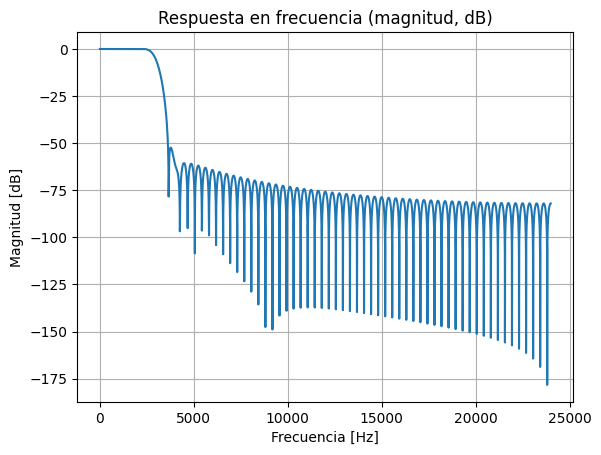

In [4]:
h = design_fir_lpf(N, fc, fs, window=window_type)
f, Hdb = freq_response(h, fs)
print('Largo del filtro:', len(h))

plt.figure()
plt.title('Respuesta en frecuencia (magnitud, dB)')
plt.plot(f, Hdb)
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.grid(True)
plt.show()

## Señal de prueba y filtrado por convolución
Acá generamos la señal, la filtramos con `np.convolve` (modo `same`) y comparamos en tiempo y frecuencia.

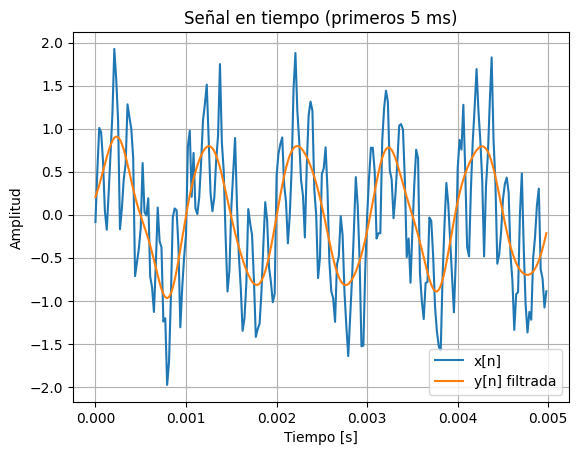

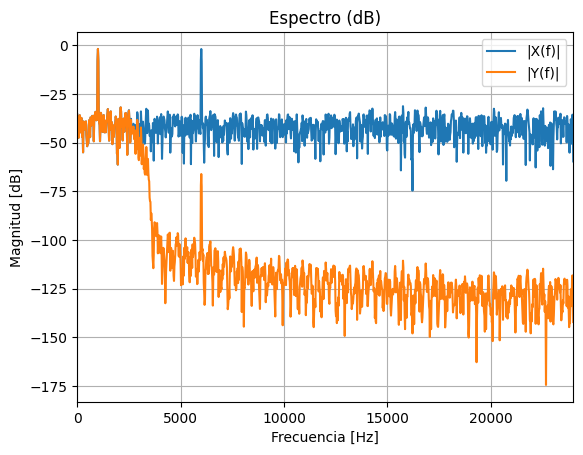

In [5]:
t, x = test_signal(fs, dur, f1, f2, noise_std)
y = np.convolve(x, h, mode='same')

# Espectros (ventana Hann para reducir leakage)
def spectrum_db(sig, fs):
    Nsig = len(sig)
    w = 0.5 - 0.5*np.cos(2*np.pi*np.arange(Nsig)/Nsig)
    S = np.abs(rfft(sig*w)) / (np.sum(w)/2)
    f = rfftfreq(Nsig, 1/fs)
    Sdb = 20*np.log10(np.maximum(S, 1e-12))
    return f, Sdb

plt.figure()
plt.title('Señal en tiempo (primeros 5 ms)')
idx = int(0.005*fs)
plt.plot(t[:idx], x[:idx], label='x[n]')
plt.plot(t[:idx], y[:idx], label='y[n] filtrada')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid(True)
plt.legend()
plt.show()

Fx, Xdb = spectrum_db(x, fs)
Fy, Ydb = spectrum_db(y, fs)
plt.figure()
plt.title('Espectro (dB)')
plt.plot(Fx, Xdb, label='|X(f)|')
plt.plot(Fy, Ydb, label='|Y(f)|')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.xlim(0, fs/2)
plt.grid(True)
plt.legend()
plt.show()

## Teorema de la Convolución (verificación numérica)
La convolución en tiempo equivale a la multiplicación en frecuencia.
Verificamos que `FFT(y) ≈ FFT(x) * FFT(h_zp)`.


In [6]:
L = len(x)
Lpad = 1
while Lpad < L:
    Lpad <<= 1
Lpad *= 2  # algo de margen

X = np.fft.rfft(x, n=Lpad)
H = np.fft.rfft(h, n=Lpad)
Y_freq = X * H
y_ifft = np.fft.irfft(Y_freq, n=Lpad)[:L]

err = np.max(np.abs(y - y_ifft))
print(f'Error máximo entre y (convolución tiempo) y IFFT(X*H): {err:.3e}')

Error máximo entre y (convolución tiempo) y IFFT(X*H): 1.602e+00


## Actividades sugeridas
1. **Variá el orden `N`**: probá con 31, 63, 127, 255. Observá el **rizado** en la banda pasante y la **pendiente** en la transición.
2. **Mové la frecuencia de corte `fc`**: acercala a 2 kHz y 4 kHz. ¿Cómo cambia la atenuación del tono de 6 kHz?
3. **Cambiá la ventana** a `'rect'` y compará con `'hamming'`. ¿Qué pasa con el rizado? ¿Y con los lóbulos laterales?
4. **Medí SNR** antes y después del filtrado: definí una función rápida que calcule SNR en banda (por ejemplo, hasta 3 kHz) e interpretá resultados.
5. **Alias y anti-alias**: antes de **diezmar por 2**, aplicá un LPF con `fc≈fs/4`. Verificá si aparece aliasing cuando no filtrás.
6. **Extra**: cambiá los tonos `f1` y `f2` para que ambos estén **dentro** de banda y compará el efecto del filtro.


## (Opcional) SNR en banda y métrica de atenuación
Ejemplo de funciones para cuantificar el efecto del filtro.

In [7]:
def band_power_db(sig, fs, fmax):
    f, Sdb = (lambda s: (rfftfreq(len(s), 1/fs), 20*np.log10(np.maximum(np.abs(rfft(s)), 1e-12))))(sig)
    mask = f <= fmax
    # Promedio en dB no es exacto para potencia total, pero sirve como métrica simple para el ejercicio
    return np.mean(Sdb[mask])

snr_in = band_power_db(x, fs, fc) - band_power_db(x, fs, fs/2)
snr_out = band_power_db(y, fs, fc) - band_power_db(y, fs, fs/2)
print(f'SNR in-band (métrica simple) — Entrada: {snr_in:.2f} dB, Salida: {snr_out:.2f} dB')

SNR in-band (métrica simple) — Entrada: 0.44 dB, Salida: 26.07 dB
